# 공부하면서 배우는 EDA (3)

**작성자 DACON ID : TDA**

이 포스팅은 데이터분석, 통계학을 실제 데이터에 응용하면서 공부하기 위해 작성된 자료입니다.

이 포스팅은 가능하다면 하루에 한 편씩 제가 수행하는 만큼 시리즈로 제작할 예정입니다.

작성자는 데이터분석, 통계학에 능통하지 않습니다. 

오히려 초보에 가깝기 때문에 수준높은 분석은 아직 어렵습니다.

만약 이 포스팅을 읽으시는 분도 저와 유사한 수준의 지식과 기술을 가지고 계시다면, 이 포스팅을 읽으시면서 공부했던 것을 복습하는 시간이 될 것이라 생각합니다.

또한 얼마든지 잘못된 분석이 있을 수 있습니다.

이에 대해 코멘트를 남겨주시면 너무 감사하겠습니다.

>본 EDA는 DACONIO님의 baseline [EDA](https://dacon.io/competitions/official/235901/codeshare/5061?page=1&dtype=recent)와 데이터 분석 교과서 'Practical Statistics for Data Scientists, 2nd edition (Peter Bruce, Andrew Bruce, Peter Gedeck)'를 참고했습니다.

# 0. 라이브러리 임포트 및 데이터 불러오기

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
%matplotlib inline  
%precision 3


# 시각화 설정
colors = [plt.cm.Dark2(i) for i in range(20)]
mpl.rcParams.update({'font.size':18})
mpl.rcParams['figure.figsize'] = 10,10

In [2]:

# csv 형식으로 된 데이터 파일을 읽어옵니다. 
train = pd.read_csv('data/train.csv')
train_clean = pd.read_csv('data/train_clean.csv')       # 지난 포스팅에서 정제한 데이터를 들고옵니다.
test = pd.read_csv('data/test.csv')

train.head()

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000


# 3. 수치형 변수 분석


이번 포스팅부터는 입력변수 분석을 시작해보겠습니다.

지난 포스팅에서 타겟 데이터를 기준으로 데이터 정제를 일차적으로 했었습니다.

따라서 여기서부터는 정제된 데이터를 가지고 분석을 진행하도록 하겠습니다.

수치형 변수는 데이터의 특성이 정량적으로 표현되는 경우를 말합니다.

수치형 변수에는 두 가지 종류가 있습니다.

- 연속형 변수 : 데이터가 실수로 표현되는 경우를 말합니다. 이 특성은 사칙연산과 순서관계 구조가 유효합니다.
- 이산형 변수 : 데이터가 정수로 표현되는 경우를 말합니다. 이 특성은 덧셈과 뺄셈, 순서관계 구조만 유효합니다.

우리의 데이터 중 수치형 변수는 `odometer`(주행거리)와 `year`(제조년도) 두 가지 입니다.

그리고 `odometer`는 연속형 변수이고, `year`는 이산형 변수에 해당합니다.

수치형 변수는 수학적으로 이해하고 이용하기가 수월합니다. 

이번 포스팅에서는 다양한 수학적 방법을 이용해 수치형 변수를 분석해보도록 하겠습니다.

## 3.1 대푯값을 이용한 수치형 변수 분석

먼저 첫 포스트에서 만들어둔 수치형 변수 분석기를 이용해 수치형 변수들을 분석해보도록 하겠습니다.

In [3]:
# 수치형변수 불러오기
odometer = train_clean.odometer
year = train_clean.year
# 수치형변수 분석기
from scipy.stats import trim_mean
import statsmodels.api as sm



def numerical_analysis(dataframe):
    # 분석을 통해 얻어지는 결과들은 dictionary에 저장합니다.
    analysis = {}

    # 위치분석
    analysis['평균'] = dataframe.mean()
    analysis['중위값'] = dataframe.median()
    
    for trim in [0.1, 0.15, 0.2, 0.25]:
        analysis[f'{trim*100}% 절사평균'] = trim_mean(dataframe, trim)
    
    # 변이분석
    analysis['분산'] = dataframe.var()
    analysis['표준편차'] = dataframe.std()
    analysis['중위절대편차'] = sm.robust.scale.mad(dataframe)

    analysis['-1sigma'] = analysis['평균'] - analysis['표준편차']
    analysis['+1sigma'] = analysis['평균'] + analysis['표준편차']

    analysis['-1MAD'] = analysis['중위값'] - analysis['중위절대편차']
    analysis['+1MAD'] = analysis['중위값'] + analysis['중위절대편차']

    # 범위분석
    analysis['최댓값'] = dataframe.max()
    analysis['최솟값'] = dataframe.min()
    analysis['범위'] = analysis['최댓값'] - analysis['최솟값']
    
    analysis['삼분위수'] = dataframe.quantile(0.75) 
    analysis['일분위수'] = dataframe.quantile(0.25)
    analysis['사분위수범위'] = analysis['삼분위수'] - analysis['일분위수']

    # 왜도와 첨도
    analysis['왜도'] = dataframe.skew()
    analysis['첨도'] = dataframe.kurt()

    return analysis

In [4]:
# odometer의 수치적분석
numerical_analysis(odometer)

{'평균': 117386.596,
 '중위값': 95850.000,
 '10.0% 절사평균': 103917.814,
 '15.0% 절사평균': 102588.450,
 '20.0% 절사평균': 101319.398,
 '25.0% 절사평균': 100193.463,
 '분산': 10914497789.380,
 '표준편차': 104472.474,
 '중위절대편차': 70287.206,
 '-1sigma': 12914.122,
 '+1sigma': 221859.070,
 '-1MAD': 25562.794,
 '+1MAD': 166137.206,
 '최댓값': 987322,
 '최솟값': 0,
 '범위': 987322,
 '삼분위수': 153413.000,
 '일분위수': 56558.000,
 '사분위수범위': 96855.000,
 '왜도': 3.179,
 '첨도': 16.602}

먼저 `odometer` 데이터의 수치적분석입니다.

첫 포스트를 참고하여 분석결과를 요약하면 다음과 같습니다.

> **위치분석결과** 
> 
> - 평균과 중위값 사이의 차이가 6000(km) 정도이고 절사평균도 균일한 것으로 보아, 데이터는 어느정도 대칭적으로 분포할 것으로 생각된다.
> 
> **변이분석결과**
> 
> - 표준편차가 100,000(km)으로 굉장히 크다. 데이터는 평균 중심으로 많이 모여있지 않을 수 있다.
> 
> **범위분석결과**
> 
> - 범위와 사분위수범위 간의 차가 굉장히 크다. (약 10배)
> - 특히 삼분위수와 최댓값 사이의 차이가 굉장히 큰 것으로 보아, 분표의 우측꼬리가 굉장히 길어지게 만드는 자료가 소수 있을 것이다. 이들은 따로 살펴볼 필요가 있을 것이다.
> 
> **왜도첨도분석**
> 
> - 왜도가 약 3(>0)이다. 데이터가 정규분포와 가까운 종모양을 띄고 있을 것이다.
> - 첨도가 약 16(>3)이다. 데이터의 꼬리가 굉장히 두꺼워, 이상치가 많을 가능성이 높다. 

분석결과 데이터가 어느정도 종 모양을 띄지만, 꼬리에 문제가 있음을 수 있음을 보여줍니다.

누군가 영업용으로 **굉장히 오래 탄 차를 중고시장에 내어놓고나 했다면, 이런 매물은 우측꼬리를 길어지게 만드는 요인**이 될 것입니다.

또 유의할 점은, 현재 데이터의 최솟값이 0인데, **주행거리가 0인 중고매물은 '미개봉중고'**와 같은 말입니다.

분명 이상한 매물이라는 것이지요. 아마도 **데이터를 생산할 때 주행거리 기입에 문제가 있었고 이를 0으로 작성했을 것**입니다.

제 개인적인 소견으로, 중고차 데이터에서 주행거리가 0이라는 것은 `null`(결측치)와 같습니다.

따라서 이 값을 어떻게 손봐줄 지 생각해봐야 합니다.

추후에 분포분석을 하면서 이런 추론이 타당한지 살펴보도록 합시다.

In [5]:

len(train_clean[odometer == 0])

'''주행거리가 0인 매물이 21개 존재합니다. 이들을 어떻게 처분할지 추후에 논의해봅시다. '''

'주행거리가 0인 매물이 21개 존재합니다. 이들을 어떻게 처분할지 추후에 논의해봅시다. '

In [6]:
# year 분석
numerical_analysis(year)

{'평균': 2009.092,
 '중위값': 2010.000,
 '10.0% 절사평균': 2010.132,
 '15.0% 절사평균': 2010.172,
 '20.0% 절사평균': 2010.167,
 '25.0% 절사평균': 2010.167,
 '분산': 654.308,
 '표준편차': 25.579,
 '중위절대편차': 5.930,
 '-1sigma': 1983.512,
 '+1sigma': 2034.671,
 '-1MAD': 2004.070,
 '+1MAD': 2015.930,
 '최댓값': 2020,
 '최솟값': 1218,
 '범위': 802,
 '삼분위수': 2014.000,
 '일분위수': 2006.000,
 '사분위수범위': 8.000,
 '왜도': -29.524,
 '첨도': 913.650}

다음으로 `year` 데이터의 수치적 분석입니다.


> **위치분석결과** 
> 
> - 평균과 중위값이 매우 유사하다. 데이터는 어느정도 대칭적으로 분포할 것으로 생각된다.
> 
> **변이분석결과**
> 
> - 표준편차가 25년으로 매우 크다. 데이터는 평균 중심으로 많이 모여있지 않을 수 있다.
> - 그런데 중위절대편차는 5로 다소 작다. 표준편차와 중위절대편차가 크게 차이나는 것으로 보아, 데이터의 꼬리에 이상치가 있을 가능성이 있다.
> 
> **범위분석결과**
> 
> - 범위와 사분위수범위 간의 차가 굉장히 크다. (약 100배)
> - 최솟값을 보니 1218(년)이 있다. 이 시기의 자동차가 있다는 것은 말이 안된다. 이는 분명 이상치다.
> 
> **왜도첨도분석**
> 
> - 왜도가 약 -29(<0)이다. 이는 데이터가 왼쪽에 긴 꼬리를 가지고, 중앙값 우측에 자료가 많음을 의미한다. 분명 1218년 때문이다 ..!
> - 첨도가 약 913(>3)이다. 데이터의 꼬리가 굉장히 두꺼워, 이상치가 많을 가능성이 높다. 

**최솟값을 보아하니 `year` 데이터에는 연도가 오기입된 데이터가 있음이 확실**합니다.

최솟값 1218 외에 혹시 또 이상한 연도가 기입된 데이터가 없는지 살펴봅시다.

In [7]:
# unique() 메서드를 사용해 데이터에 포함된 값들을 살펴보면 이상한 값이 있는지 쉽게 알아볼 수 있다.
year.unique()

array([2016, 2019, 2012, 2007, 2010, 2004, 2008, 2018, 2009, 2013, 1996,
       2014, 2002, 2006, 2017, 1998, 2011, 2005, 2000, 2015, 2001, 1995,
       2003, 1999, 1985, 2020, 1994, 1991, 1218, 1982, 1997, 1980])

자료를 살펴본 결과 year 값이 1218인 데이터만 소거하면 될 것 같습니다.

이 데이터 하나를 정제하는 데에 많은 시간을 쓰느니 제거하는 편이 나을 것 같습니다.

이에 따라 우리의 데이터셋을 수정합니다.

In [8]:
train_clean = train_clean[year > 1218]
train_clean

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000
...,...,...,...,...,...,...,...,...,...,...,...
1000,1010,Toyota Corolla,46768,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2014,5415000
1001,1011,Toyota Camry,31600,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,Silver,2011,3615000
1002,1012,Toyota Camry,96802,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2011,3415000
1003,1013,Lexus GX 460,146275,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Gold,2013,14315000


In [9]:
# 데이터셋을 수정했으므로, odometer와 year도 새롭게 수정합니다.

odometer = train_clean.odometer
year = train_clean.year

In [10]:
numerical_analysis(year)

{'평균': 2009.879,
 '중위값': 2010.000,
 '10.0% 절사평균': 2010.141,
 '15.0% 절사평균': 2010.180,
 '20.0% 절사평균': 2010.175,
 '25.0% 절사평균': 2010.175,
 '분산': 30.385,
 '표준편차': 5.512,
 '중위절대편차': 5.930,
 '-1sigma': 2004.367,
 '+1sigma': 2015.392,
 '-1MAD': 2004.070,
 '+1MAD': 2015.930,
 '최댓값': 2020,
 '최솟값': 1980,
 '범위': 40,
 '삼분위수': 2014.000,
 '일분위수': 2006.000,
 '사분위수범위': 8.000,
 '왜도': -0.682,
 '첨도': 1.399}

수정 후 `year` 데이터의 수치적 분석을 살펴보니, 대부분의 통계량들이 안정적인 값을 보입니다.

데이터는 상당히 대칭적인 것으로 보입니다. 

다만, 왜도와 첨도 값을 보건데 그 모양이 정규분포의 종모양처럼 분포하지는 않을 듯 합니다.

이제 데이터 분포를 이용한 분석을 통해 시각적으로 데이터를 살펴봅시다.

## 3.2 데이터 분포를 이용한 수치형 변수 분석

이번에는 데이터의 분포를 살펴볼 수 있는 다양한 방법들로 수치형 변수를 분석해봅시다.

지난 포스팅에서 살펴본 박스 플롯, 도수분포표, 히스토그램, 커널밀도추정을 각각 살펴봅니다.

먼저 `odometer`부터 살펴봅시다.

Text(0.5, 0.98, 'Odometer')

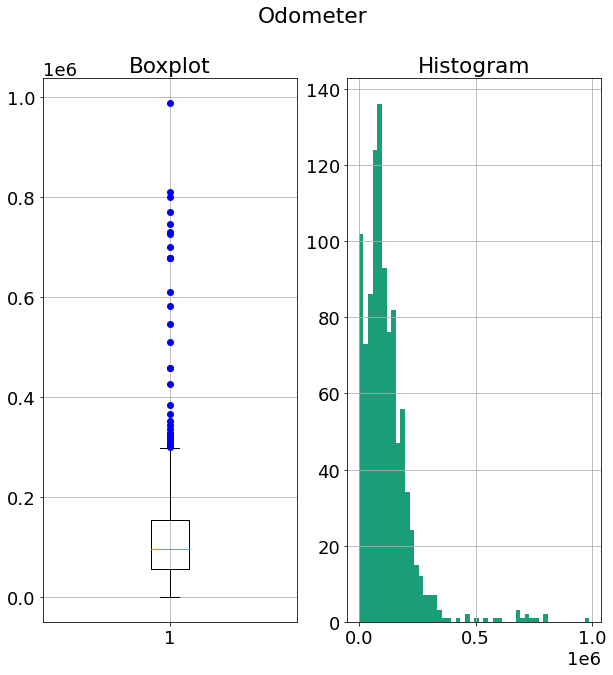

In [11]:
# Boxplot & Histogram

fig, ax = plt.subplots(1,2, figsize = (10,10))

ax[0].boxplot(odometer, 
            sym = 'bo',     # anomaly를 파란 동그라미로 표시합니다.
            )
ax[0].set_title('Boxplot')
ax[0].grid()
ax[1].hist(odometer, bins = 50, color = colors[0])
ax[1].set_title('Histogram')
ax[1].grid()

fig.suptitle('Odometer')


분포를 살펴본 결과, 이 데이터 분포의 두 가지 문제점을 발견했습니다.

1. 앞서 예상한대로 0의 값을 가진 데이터가 많습니다. 이 데이터는 왼쪽 꼬리를 부자연스럽게 만들고 있습니다.
2. 사분위수 바깥에 위치한 데이터가 많습니다. 먼저 0 값을 가진 데이터들을 수정하고 나면, 이 값은 어느정도 조정이 될 수도 있습니다.

그렇다면 이 결측치 0을 어떻게 처리하면 좋을까요?

일반적으로 이 결측치들을 처리하는 방법은 1) 제거하거나 2) 평균값으로 부여하거나 입니다.

0 값을 가지는 데이터는 총 21개가 존재했었습니다.

이 데이터들을 한번 살펴봅시다.

In [12]:
# 미개봉 중고 데이터들을 살펴보자.
unopened_used = train_clean[odometer == 0]
unopened_used

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
52,52,Mitsubishi CANTER PICK UP,0,Lagos,Locally used,4-cylinder(I4),manual,diesel,green,2006,5535000
121,121,Man TGA 18.360,0,Lagos,Locally used,6-cylinder(V6),manual,diesel,white,2004,8515000
134,134,Nissan Cabstar,0,Lagos,Locally used,4-cylinder(I4),manual,diesel,white,2006,3015000
176,176,IVM LT35,0,Lagos,Locally used,4-cylinder(I4),manual,diesel,blue,2003,2890000
260,260,Mercedes-Benz GLC 300,0,Abuja,Foreign Used,6-cylinder(I6),automatic,petrol,White,2018,18515000
301,301,Scania P94 FLATBED,0,Lagos,Locally used,6-cylinder(I6),manual,diesel,red,1999,5360000
349,351,Volvo FL6,0,Lagos,Locally used,6-cylinder(I6),manual,diesel,white,1996,6915000
350,352,Toyota Coaster,0,Lagos,Locally used,4-cylinder(I4),manual,diesel,yellow,2014,16690000
370,372,Toyota Camry,0,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Blue,2003,1715000
381,383,Mack CH613,0,Lagos,Locally used,6-cylinder(V6),manual,diesel,white,1995,8015000


21개의 매물이 존재합니다.

이 데이터들을 얼핏봐서는 odometer 외에는 다른 변수들에 문제가 없어 보입니다.

이 값들도 일단은 따로 떼어둔 뒤, 통계량과 분포가 어떻게 변하는지 살펴봅시다.

만약 그렇게 했을 때 분포가 안정적으로 변한다면 저는 이 데이터들의 odometer를 평균으로 부여한 뒤 다시 첨가시킬 것입니다.

그러나, 제거를 했을 때에도 분포가 안정적으로 변하지 않는다면 아직 이 데이터들을 사용하길 보류할 것입니다.

In [13]:
temp = train_clean[odometer > 0]
numerical_analysis(temp.odometer)

{'평균': 119603.325,
 '중위값': 97488.000,
 '10.0% 절사평균': 106035.799,
 '15.0% 절사평균': 104601.055,
 '20.0% 절사평균': 103245.069,
 '25.0% 절사평균': 102013.572,
 '분산': 10776084516.617,
 '표준편차': 103807.921,
 '중위절대편차': 68224.906,
 '-1sigma': 15795.403,
 '+1sigma': 223411.246,
 '-1MAD': 29263.094,
 '+1MAD': 165712.906,
 '최댓값': 987322,
 '최솟값': 10,
 '범위': 987312,
 '삼분위수': 154790.000,
 '일분위수': 60370.500,
 '사분위수범위': 94419.500,
 '왜도': 3.259,
 '첨도': 17.186}

Text(0.5, 0.98, 'Odometer')

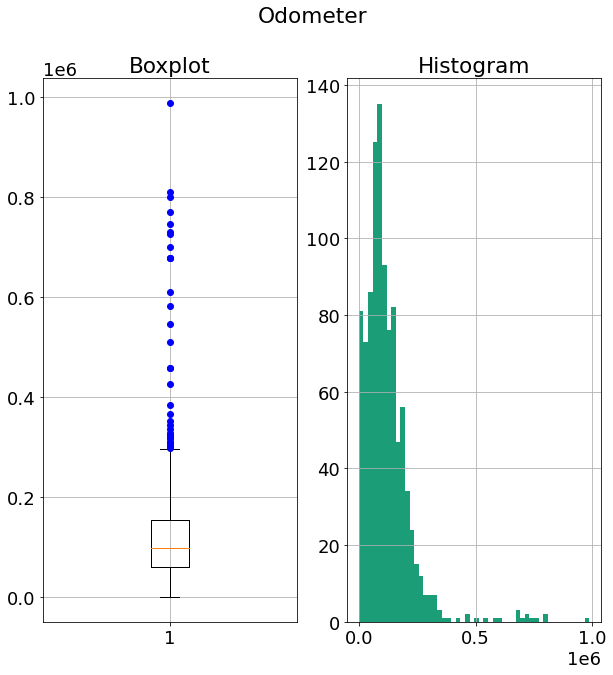

In [14]:
# Boxplot & Histogram

fig, ax = plt.subplots(1,2, figsize = (10,10))

ax[0].boxplot(temp.odometer, 
            sym = 'bo',     # anomaly를 파란 동그라미로 표시합니다.
            )
ax[0].set_title('Boxplot')
ax[0].grid()
ax[1].hist(temp.odometer, bins = 50, color = colors[0])
ax[1].set_title('Histogram')
ax[1].grid()

fig.suptitle('Odometer')


이전과 비교해서 분포가 딱히 **유의미하게 변하지 않는 것**으로 보입니다.

따라서 저는 해당 21개의 데이터는 따로 저장해둔 뒤 일단은 **이 데이터를 제거한 것**을 사용할 것입니다.


In [15]:
# 미개봉 중고를 저장하자.
unopened_used.to_csv('data/unopened_used.csv')

In [16]:
# 미개봉 중고를 제외한 데이터를 새롭게 업데이트하고, 이를 저장하자.
train_clean = train_clean[odometer > 0]
train_clean.to_csv('data/train_clean2.csv')
train_clean

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000
...,...,...,...,...,...,...,...,...,...,...,...
999,1009,Man BOCKMANN,809456,Lagos,Locally used,6-cylinder(V6),manual,diesel,white,1980,26015000
1000,1010,Toyota Corolla,46768,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2014,5415000
1001,1011,Toyota Camry,31600,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,Silver,2011,3615000
1002,1012,Toyota Camry,96802,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2011,3415000


데이터를 수정도 하였으니, 도수분포표와 커널밀도추정으로도 데이터를 살펴봅시다.

도수분포표를 활용하면, 어느 구간에서 몇 개의 데이터가 모였는지 수치로 볼 수 있기 때문에 유용하며,

이를 참고하여 커널밀도추정을 살펴보면 어느 구간에서 데이터가 정규분포 양상을 띄는지 관찰할 수 있습니다.

In [37]:
# 사용할 데이터셋이 바뀌었으니, 다시 odometer와 year, 그리고 target을 업데이트합시다.
odometer = train_clean.odometer
year = train_clean.year
target = train_clean.target

In [38]:
# 도수분포표
binned = pd.cut(odometer, 10)
binned.value_counts()

(-977.312, 98741.2]     500
(98741.2, 197472.4]     354
(197472.4, 296203.6]     92
(296203.6, 394934.8]     19
(691128.4, 789859.6]      5
(592397.2, 691128.4]      4
(394934.8, 493666.0]      3
(493666.0, 592397.2]      3
(789859.6, 888590.8]      2
(888590.8, 987322.0]      1
Name: odometer, dtype: int64

/Users/shlee/miniforge3/envs/dacon/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



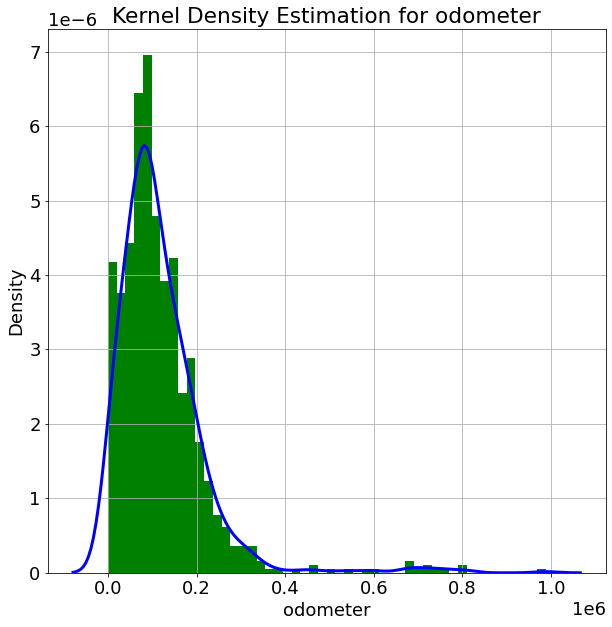

In [39]:
# 커널밀도추정
sns.distplot(odometer, 
            kde_kws={"color": "b", "lw": 3, "label": "KDE"},
            hist_kws={"histtype": "bar", "linewidth": 3,
                            "alpha": 1, "color": "g"})

plt.title('Kernel Density Estimation for odometer')
plt.grid()

이제 수정된 데이터를 토대로 odometer의 분포에 대한 분석 결과를 요약해봅시다.

> **박스플롯결과** 
> 
> - 박스플롯의 윗수염 외부에 여러 이상치들이 존재한다. 그런데 이상치들도 어느정도 군집을 이루고 있다. 
> 
> **도수분포표결과**
> 
> - 낮은 계급에 데이터가 매우 밀집되어 있다. 상위 계급으로 갈 수록 데이터가 급격히 줄어든다.
> - 조금 더 구체적으로, 주행량 20만 이하의 매물이 대부분이다. 연식과 비교해보아야 하겠지만, 주행거리 10만이면 꽤나 많이 탄 차량이기 때문에 중고가도 많이 떨어진다고 한다. 20만 정도면 중고차 시장에서 수요되는 거의 마지노선이 아닐까 싶다. (이는 한국 기준으로, 데이터셋의 원산지인 나이지리아 환경은 다를 수 있다.)
> - 30만 이상의 주행거리를 보이는 데이터는 그 양도 적지만, 실제 그런 매물이 등장하기도 어렵고 거래되기도 어려울 것이다. 만약 거래가 된다고 해도 거의 가격이 매우 낮을 것이다. 이들 데이터를 위해 복잡한 모델을 설계하는 것은 괜한 일일 수도 있다.
> 
> **히스토그램분석결과**
> 
> - 낮은 값과 꼬리쪽에 분포를 부드럽게하지 못하는 데이터가 존재한다. 물론 이는 데이터가 부족해서 그럴 수 있다.
> 
> **커널밀도분석**
> 
> - 데이터가 밀집된 낮은 영역은 조금 뾰족한 종모양을 이루고 있다. 이 종모양 근처의 데이터는 도수분포표를 참고로 했을 때, 실제 거래되기에 적합한 데이터들이라 생각된다. 앞으로도 이런 양상으로 데이터가 수집될 가능성이 높아보인다.

데이터를 분리했으니, 또 보고서를 써둡시다.

> **데이터 분리 보고서**
> 
> - 원본 데이터 : `train.csv`
> - 1차 분할 : `train_clean.csv`(사용), `train_outlier.csv`(보관)
>   - 사유 1 : 데이터분석 결과 높은 target 값에서 오기입된 것으로 추정되는 데이터가 발견되어, 이들을 수정할 필요가 있음.
>   - 사유 2 : target이 로그정규분포를 띄는 양상을 보이고 있어, target의 log에 대한 박스플롯 외부의 아웃라이어들은 사유 1에 해당하는 데이터도 포함되기에 제거하기로함.
> 
> - 2차 분할 : `train_clean2.csv`(사용), `unopened_used.csv`(보관)
>   - 사유 1 : odometer 값이 0인 데이터들은 결측치로 추정되고, 이를 제거해도 분포에 유의미한 영향을 주지 않으므로 제거하기로 함.

다음으로 연식 데이터 `year`를 분석해봅시다.

Text(0.5, 0.98, 'Year')

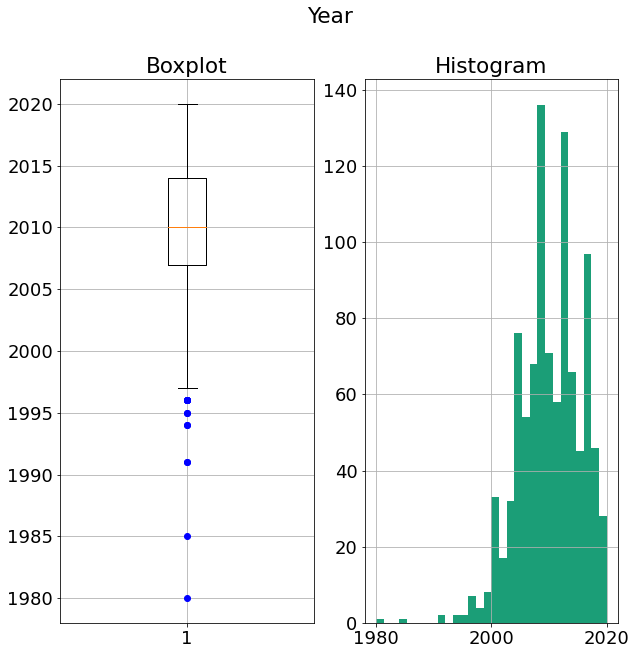

In [40]:
# Boxplot & Histogram

fig, ax = plt.subplots(1,2, figsize = (10,10))

ax[0].boxplot(year, 
            sym = 'bo',     # anomaly를 파란 동그라미로 표시합니다.
            )
ax[0].set_title('Boxplot')
ax[0].grid()
ax[1].hist(year, bins = len(year.unique()), color = colors[0])
ax[1].set_title('Histogram')
ax[1].grid()

fig.suptitle('Year')


In [41]:
# 도수분포표
binned = pd.cut(year, 10)
binned.value_counts()

(2012.0, 2016.0]     252
(2004.0, 2008.0]     242
(2008.0, 2012.0]     242
(2000.0, 2004.0]     105
(2016.0, 2020.0]     103
(1996.0, 2000.0]      25
(1992.0, 1996.0]      10
(1988.0, 1992.0]       2
(1979.96, 1984.0]      1
(1984.0, 1988.0]       1
Name: year, dtype: int64

/Users/shlee/miniforge3/envs/dacon/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



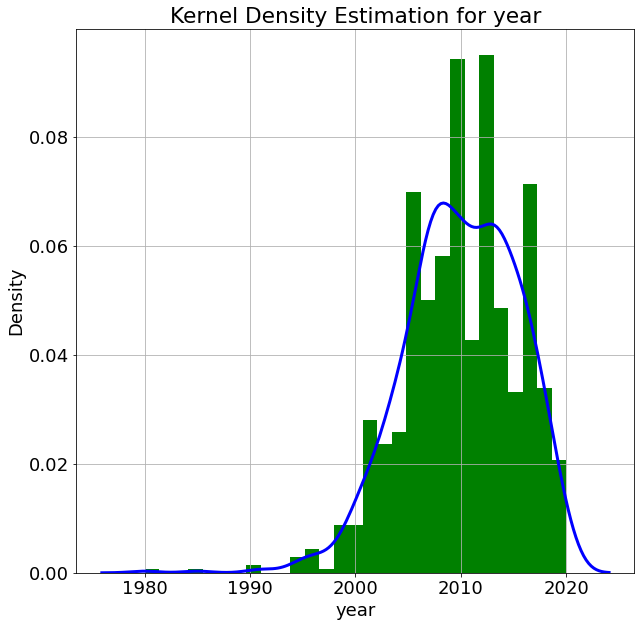

In [42]:
# 커널밀도추정
sns.distplot(year, 
            kde_kws={"color": "b", "lw": 3, "label": "KDE"},
            hist_kws={"histtype": "bar", "linewidth": 3,
                            "alpha": 1, "color": "g"})

plt.title('Kernel Density Estimation for year')
plt.grid()

> **박스플롯결과** 
> 
> - 박스플롯의 아랫수염 외부의 아웃라이어들이 약간 보인다. 이들은 꽤나 연식이 오래된 매물이다. 30-40년 이상된 매물들로, 이들이 앞으로도 수집될 확률은 낮아보인다. 이들을 제거하는 것도 생각해볼만 하다.
>
> **히스토그램분석결과**
> 
> - 특정 몇 개의 연식을 가지는 차량이 많다. 해당 연식의 차량이 특별히 많은 데에는 어떤 이유가 있는 듯 하다. 그러나 이 이유를 분석하려면 도메인 지식이 상당히 필요해보인다. 그냥 놔두는 것이 좋아보인다.
> 
> **도수분포표결과**
> 
> - 대부분의 매물은 2000년에서 2020년 사이에 존재한다. 
> - 4년 단위로 매물은 거의 균일하게 분포한다.
> - 2004년에서 2016년까지 연식을 가지는 차량들의 매물이 가장 많다. 차를 길게 타야 15년 정도 타고서 판매한다는 점을 생각하면, 이는 자연스러운 현상이다. 즉, 가장 최근연식는 아직 팔기에 너무 일러서 매물이 상대적으로 적고, 너무 오래된 연식은 더 이상 상품가치가 없어서 매물로 잘 나오지 않는 것이다.
> - 이런 특성을 고려하면, 만약 이 데이터를 참고하여, 자동 예측모델을 상용화한다고 할 때, 연도특성은 고정값이 아닌, 현재 시점을 기준으로 상대적인 값으로 지정하도록 변환해야할 것이다. 그래야 실시간으로 변화하는 상품의 가치를 반영할 수 있기 때문이다.
> 
> **커널밀도분석**
> 
> - 데이터의 분포가 마치 어린왕자에 나오는 보아뱀 모양이다. 이 특성은 정규성을 띄지 않으므로, 특성의 정규성에 영향을 받는 모델은 이 특성을 고려하지 않도록 하는 것이 좋을 것이다.

## 3.2 상관관계분석

수치형 데이터 분석에서 빼놓을 수 없는 부분이 입력변수와 예측변수 사이의 상관관계 측정입니다.

상관관계가 인과관계를 말해주지는 않지만, 두 변수간의 선형적인 비례관계에 대한 특성을 파악할 수 있어 유용한 직관을 가져다 줍니다. 

그렇다면 상관관계란 무엇이며, 이는 어떻게 측정하는 것일까요?

이를 위해 먼저 **공분산** 개념을 알 필요가 있습니다.

> **공분산**
> 2개의 연속형 변수 $X$, $Y$에 대하여, 공분산 $Cov(X,Y)$는 다음과 같이 정의한다.
> $$ Cov(X,Y) = \frac{1}{N}\sum_{i=1}^N(X_i-\mu_X)(Y_i-\mu_Y)$$
> 여기서 $\mu_X, \mu_Y$는 각각 변수 $X$와 $Y$에 대한 표본의 평균이다.
> 공분산은 다음과 같은 특징을 가진다.
> - **$Cov(X,Y) > 0$** : 두 변수 $X$와 $Y$는 비례관계를 가진다.
> - **$Cov(X,Y) < 0$** : 두 변수 $X$와 $Y$는 반비례관계를 가진다.
> - **$Cov(X,Y) = 0$** : 두 변수 사이에 선형적인 관계성이 없다.

공분산은 두 변수에 대한 상관관계를 말해줍니다.

우리가 예상하기에 주행거리와 가격은 반비례관계를 가질 것 같습니다.

실제로 그러한지 수치적으로 확인하는 방법은 주행거리와 가격에 대한 공분산을 구해보는 것입니다.

만약 공분산이 음수가 나온다면, 우리의 추측이 어느정도 타당하다고 생각할 수 있을 것입니다.

공분산은 편리한 지표이지만, 최댓값이나 최솟값이 얼마가 될지 알 수 없습니다.

그래서 일반적으로 공분산을 표준화한 **피어슨 상관계수**를 사용합니다.

피어슨 상관계수는 다음과 같이 정의됩니다.

$$\rho_{XY} = \frac{Cov(X,Y)}{Var(X)Var(Y)}$$

여기서 $Var(X), Var(Y)$는 각각 변수 $X$와 $Y$에 대한 표본의 분산입니다.

피어슨 상관계수는 -1과 1 사이의 값을 가지기 때문에 사용하기에 편리합니다.

피어슨 상관계수가 나타내는 의미는 공분산과 일맥상통합니다.

그리고 이것을 **상관관계**라고 부릅니다.


>**주의!** 상관관계는 만능이 아닙니다! 데이터가 비선형적인 관계를 띌 경우 상관계수는 0에 가까운 값을 가집니다. 이는 두 데이터가 상관없다거나 독립을 의미하는 것이 아님에 주의하세요! 특히, 상관관계와 인과관계는 다릅니다!

데이터의 상관행렬은 다음의 코드로 쉽게 구할 수 있습니다.

In [43]:
# 먼저 수치형 데이터만 따로 걸러내자.
numeric_features = ['odometer', 'year', 'target']
train_numeric = train_clean[numeric_features]

In [44]:
# DataFrame의 corr() 메서드를 사용하면 수치형 데이터의 상관관계행렬 (Correlation matirx)를 출력해준다.
train_numeric.corr()

,odometer,year,target
odometer,1.000000,-0.560205,-0.318287
year,-0.560205,1.000000,0.560564
target,-0.318287,0.560564,1.000000


Text(0.5, 1.0, 'Correlation between numeric features')

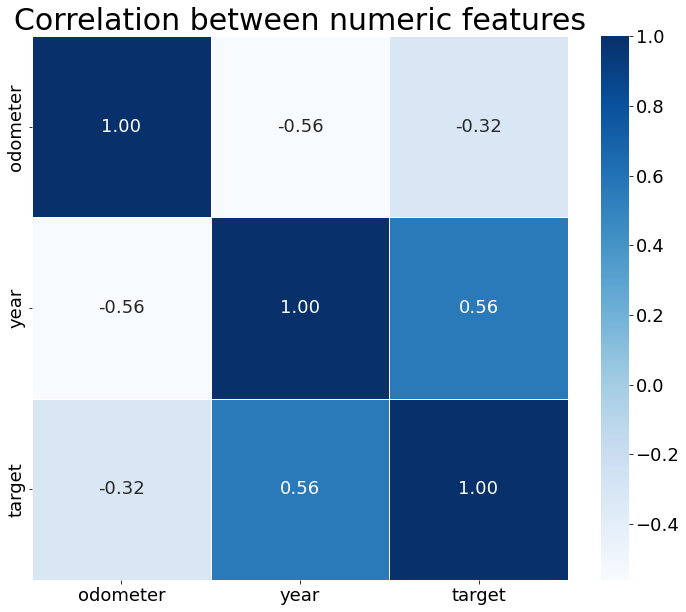

In [45]:
# 시각화 라이브러리들의 heatmap 기능을 사용하면 이를 조금 더 예쁘게 볼 수 있다.
# (DACONIO님의 코드 참고)
plt.figure(figsize=(12,10))
sns.heatmap(data = train_numeric.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.title('Correlation between numeric features', fontsize=30)

상관관계분석의 결과를 해석하면 다음과 같습니다.

> **상관관계분석**
>
> - target과 year(연식)은 양의 상관관계를 가진다. 최신 차량일 수록 비싼 중고가를 형성한다는 점에서 타당해보인다.
> - target과 odometer는 음의 상관관계를 가진다. 주행거리가 클수록 저렴한 중고가를 형성한다는 점에서 타당해보인다.

## 3.3 산점도 (산포도)

상관관계는 수치적으로 두 변수 사이의 관계를 말해줬습니다.

그러나, 이 값이 직관적으로 어떤 관계를 띄는지 보려면 두 데이터의 상관관계를 산점도로 나타내는 것이 좋습니다.

산점도를 그리는 방법은 매우 간단합니다.

각 $i$번째 샘플에 대하여, 이들의 $X,Y$ 특성 값인 $X_i,Y_i$를 좌표평면 위에 $(X_i,Y_i)$로 표기하는 것입니다.

이렇게 모든 데이터 샘플에 대해 점을 찍으면 산점도가 완성됩니다.

`pandas.plotting`의 `scatter_matrix` 함수는 수치형 변수로 구성된 데이터에 대해 산점도를 매우 손쉽게 그려줍니다.

`scatter_matrix`의 결과물은 행에 해당하는 특성과 열에 해당하는 특성을 각각 $X,Y$로 놓고 산점도를 그립니다.

대각성분은 서로 같은 특성끼리의 산점도를 찍는 것 대신, 해당 특성에 대한 히스토그램을 그려줍니다.

array([[<AxesSubplot:xlabel='odometer', ylabel='odometer'>,
        <AxesSubplot:xlabel='year', ylabel='odometer'>,
        <AxesSubplot:xlabel='target', ylabel='odometer'>],
       [<AxesSubplot:xlabel='odometer', ylabel='year'>,
        <AxesSubplot:xlabel='year', ylabel='year'>,
        <AxesSubplot:xlabel='target', ylabel='year'>],
       [<AxesSubplot:xlabel='odometer', ylabel='target'>,
        <AxesSubplot:xlabel='year', ylabel='target'>,
        <AxesSubplot:xlabel='target', ylabel='target'>]], dtype=object)

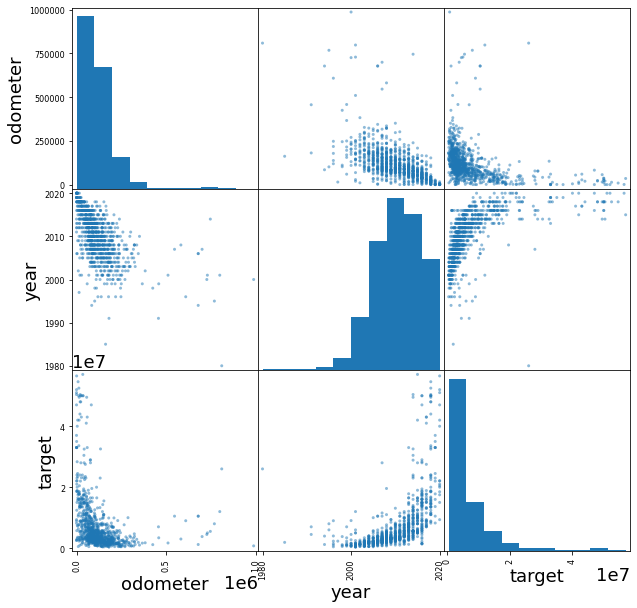

In [46]:
# 산점도
from pandas.plotting import scatter_matrix

scatter_matrix(train_numeric, figsize = (10,10))

산점도를 살펴보니 target과 나머지 두 변수들이 확실히 비례 또는 반비례 관계를 가지는 것이 관찰됩니다.

그런데 제 눈에만 그렇게 보이는 것일까요?

각 **특성들이 선형적인 관계보다는 지수함수적인 관계를 띄는 것** 같습니다.

특히나 우리는 이전의 분석에서 target 대신 target에 log를 취하였을 때에 주목했었습니다.

실제로 데이터가 지수적인 관계를 띄는게 맞다면, target에 log를 취해 산점도를 그렸을 때엔 선형적인 관계를 띌 것입니다.

> *왜 그럴까요?*
> 
> $X$와 $Y$가 지수함수의 관계 $Y= ae^{X}$로 근사된다고 합시다.
> 이때 양 변에 로그를 취하면, $\log{Y} = \log{a}+X = X + c$가 되어 선형적인 관계가 됨을 알 수 있습니다.

이제 수치형변수에 target의 log값을 추가해 다시 산점도를 그려봅시다.

/var/folders/f_/8q99w4md3hb8qbyr7lt7v7r00000gn/T/ipykernel_25521/3528200625.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array([[<AxesSubplot:xlabel='odometer', ylabel='odometer'>,
        <AxesSubplot:xlabel='year', ylabel='odometer'>,
        <AxesSubplot:xlabel='target', ylabel='odometer'>,
        <AxesSubplot:xlabel='target_log', ylabel='odometer'>],
       [<AxesSubplot:xlabel='odometer', ylabel='year'>,
        <AxesSubplot:xlabel='year', ylabel='year'>,
        <AxesSubplot:xlabel='target', ylabel='year'>,
        <AxesSubplot:xlabel='target_log', ylabel='year'>],
       [<AxesSubplot:xlabel='odometer', ylabel='target'>,
        <AxesSubplot:xlabel='year', ylabel='target'>,
        <AxesSubplot:xlabel='target', ylabel='target'>,
        <AxesSubplot:xlabel='target_log', ylabel='target'>],
       [<AxesSubplot:xlabel='odometer', ylabel='target_log'>,
        <AxesSubplot:xlabel='year', ylabel='target_log'>,
        <AxesSubplot:xlabel='target', ylabel='target_log'>,
        <AxesSubplot:xlabel='target_log', ylabel='target_log'>]],
      dtype=object)

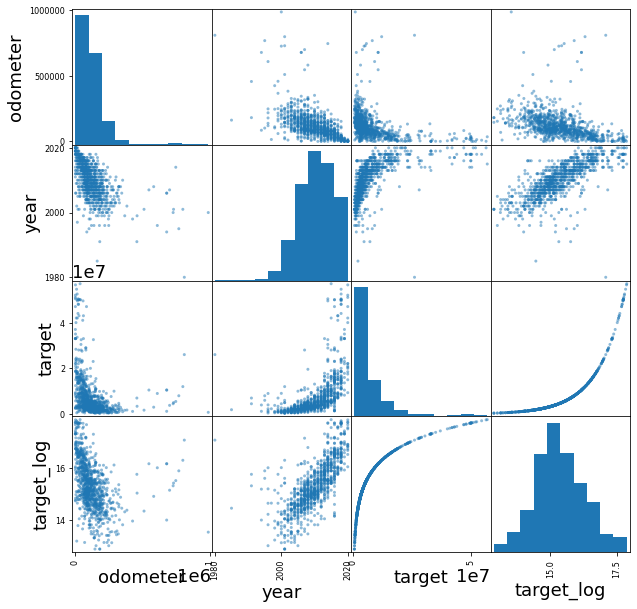

In [54]:
target_log = np.log(target)
train_numeric['target_log'] = target_log
scatter_matrix(train_numeric, figsize = (10,10))

Text(0.5, 1.0, 'Correlation between numeric features')

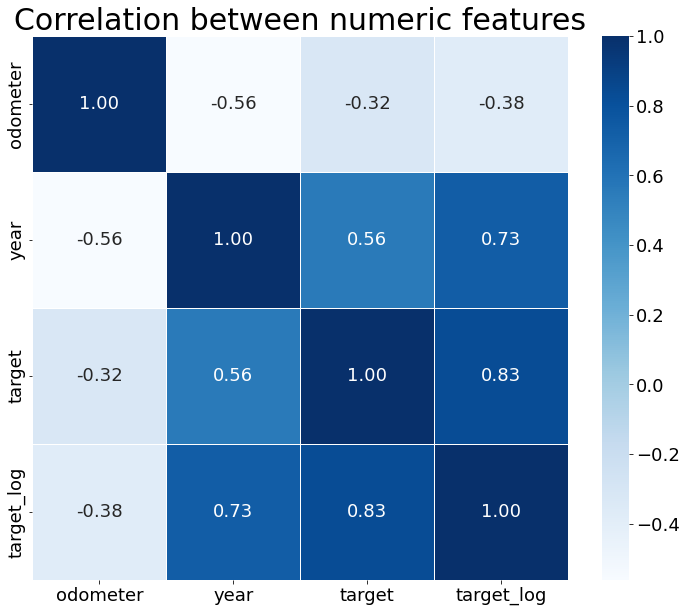

In [55]:
plt.figure(figsize=(12,10))
sns.heatmap(data = train_numeric.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.title('Correlation between numeric features', fontsize=30)

제 예상이 맞았던 것 같습니다!

**두 입력변수 특성들과 target_log 간에는 훨씬 선형적인 관계**가 두드러져 보입니다.

특히 `year`의 경우 target_log와의 상관계수 값이 0.73으로 매우 높군요!

이 정도 선형성이라면, **수치형 변수를 이용해 선형회귀를 하는 것으로도 좋은 점수를 얻을 수 있을 것 같습니다**.

이 점을 정리해둡시다.

>**산점도분석**
> - target_log와 odometer, year 간에는 강한 선형성이 관찰된다.
> - 이 관계를 이용하면 선형모델이 좋은 성능을 낼 수 있어보인다.


## 3.4 다변수분석

지금까지는 하나의 독립적인 변수만을 분석하거나, 입력변수 하나와 타겟변수 하나를 대응시켜 분석했습니다.

이번에는 두 개 이상의 변수와 하나의 타겟변수를 대응시켜 복합적으로 분석하는 방법을 살펴보도록 하겠습니다.

이 문제의 경우 입력변수가 2개, 타겟변수가 1개이기 때문에 3차원 시각화를 시도해볼 수 있을 것입니다.

3차원 시각화에는 Point cloud로 시각화하는 방법, 육각형 구간 방법, 등고선 방법 등이 있습니다.

여기서는 `matplotlib`과 `plotly`를 이용해 Point cloud로의 시각화를 시도해보겠습니다.

/var/folders/f_/8q99w4md3hb8qbyr7lt7v7r00000gn/T/ipykernel_25521/2214000866.py:4: MatplotlibDeprecationWarning:

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().



Text(0.5, 0.98, '3D scatter for numerical data')

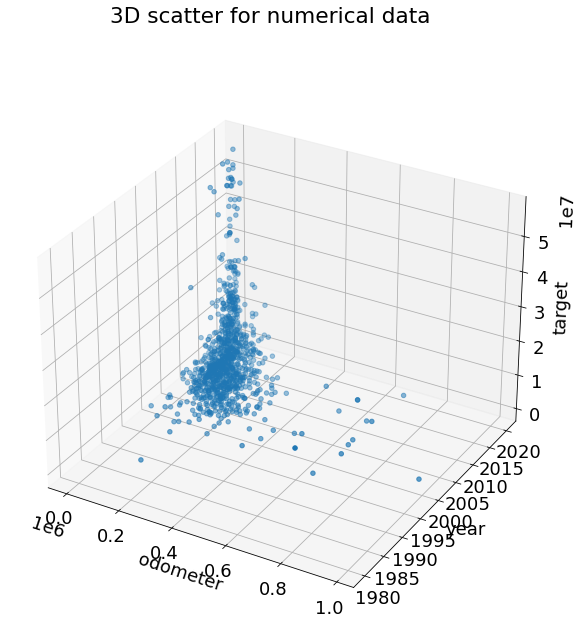

In [56]:
# matplotlib을 이용한 point cloud형 시각화

fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection = '3d')

X = odometer
Y = year
Z = target

ax.scatter(X,Y,Z)
ax.set_xlabel('odometer')
ax.set_ylabel('year')
ax.set_zlabel('target')

fig.suptitle('3D scatter for numerical data')

/var/folders/f_/8q99w4md3hb8qbyr7lt7v7r00000gn/T/ipykernel_25521/567315998.py:4: MatplotlibDeprecationWarning:

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().



Text(0.5, 0.98, '3D scatter for numerical data')

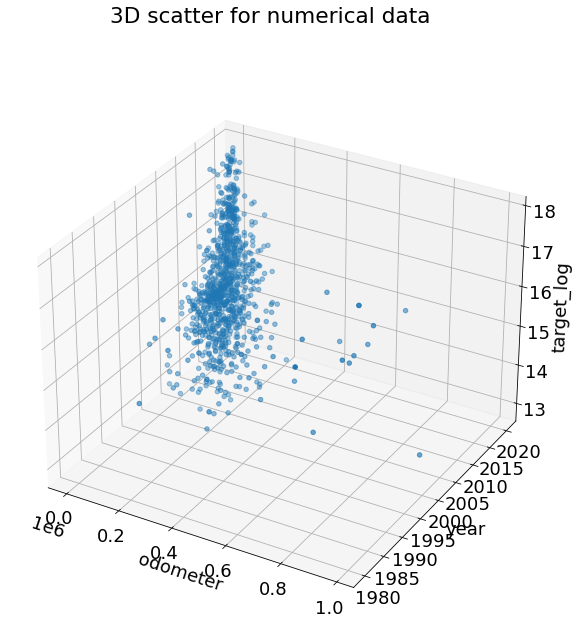

In [57]:
# matplotlib을 이용한 point cloud형 시각화

fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection = '3d')

X = odometer
Y = year
Z = target_log

ax.scatter(X,Y,Z)
ax.set_xlabel('odometer')
ax.set_ylabel('year')
ax.set_zlabel('target_log')

fig.suptitle('3D scatter for numerical data')

matplotlib을 활용해서 시각화를 했더니 애석하게도 바라보는 시점이 좋지가 않습니다.

물론 설정을 바꾸면 회전이 가능하지만, 이를 일일이 조절하기엔 번거롭습니다.

`plotly`를 활용하면 회전이나 확대 축소와 같은 기능이 내장된 시각화 결과물을 얻을 수 있습니다.

이렇게 그리면 회전을 하고 확대 축소를 하면서 데이터 산점도에 대해 직관을 얻기에 더 쉬울 것입니다.

In [59]:
# plotly를 활용한 시각화

import plotly.express as px

fig = px.scatter_3d(train_numeric, x = 'odometer', y = 'year', z = 'target')
fig.update_traces(marker_size = 2)
fig.show()

앞서 분석한 결과에 따르면, odometer와 target은 지수함수와 같은 경향성을 띄는 것으로 보이고, year와 target도 지수함수와 같은 경향성을 띄는 듯 했습니다.

그런 점에서 위 그림이 target과 (odemeter, year)의 관계는 다변수 지수함수와 같은 형태를 띄는 것처럼 보이는 것은 자연스러운 결과입니다.

위 그림을 살펴보면 동떨어진 점 하나가 존재하는데, 마우스 커서를 올리면 어떤 변수를 가진 점인지 알 수 있습니다.

odometer = 809.456k, year=1980, target=26.015M인 데이터가 굉장히 동떨어져 있습니다.

이 데이터는 애초에 year가 1980인것부터 맘에 들지 않았는데 outlier로 이렇게 잡히는 것으로 보아 제거하는 것이 좋아 보입니다.

또한 outlier들이 대체로 매우 오래된 연식의 매물들임을 알 수 있습니다.

이로부터 **대략 2000년 근방 혹은 그 이전의 연식을 가진 매물들은 분석 후 제거해도 좋을 것 같다**는 직관을 얻을 수 있습니다.



In [60]:
# plotly를 활용한 시각화

import plotly.express as px

fig = px.scatter_3d(train_numeric, x = 'odometer', y = 'year', z = 'target_log')
fig.update_traces(marker_size = 2)
fig.show()

이번에는 target_log에 대하여 point cloud를 살펴보았습니다.

데이터들이 매우 선형적인 관계를 잘 보이는 것을 알 수 있습니다.

이를 정리해봅시다.

> **산점도분석**
> - 수치형입력변수 odometer,year와 target은 다변수지수함수 형태를 띈다.
> - 수치형입력변수 odometer,year와 target_log는 다변수선형함수 형태를 띈다.
> - 2000년 이전의 연식을 가지는 데이터는 분석 후 제거하는 것이 좋아보인다.

일단 2000년 이전의 연식을 가지는 데이터를 분석하는 일은 추후로 미뤄두고, 오늘은 콕 집어 발견된 1980년 데이터를 제거한 다음 분석을 계속해나가도록 하겠습니다.

In [69]:
train_clean = train_clean[year > 1980]

/var/folders/f_/8q99w4md3hb8qbyr7lt7v7r00000gn/T/ipykernel_25521/3067327348.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [90]:
train_numeric = train_clean[numeric_features]
train_numeric['target_log'] = np.log(train_numeric['target'])
train_numeric

/var/folders/f_/8q99w4md3hb8qbyr7lt7v7r00000gn/T/ipykernel_25521/712160314.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,odometer,year,target,target_log
0,18277,2016,13665000,16.430348
1,10,2019,33015000,17.312473
2,83091,2012,9915000,16.109559
3,91524,2007,3815000,15.154451
4,94177,2010,7385000,15.814961
...,...,...,...,...
998,78984,2014,4915000,15.407802
1000,46768,2014,5415000,15.504683
1001,31600,2011,3615000,15.100602
1002,96802,2011,3415000,15.043688


## 3.5 선형모델

앞서 살펴본 분석결과, 수치형 변수를 이용해 선형모델을 시도해보는 것이 굉장히 유용해보입니다.

선형모델에는 기본적인 선형회귀부터, SVM, Ridge 등의 모델이 있습니다. 

여기서는 다양한 선형모델들을 테스트해보고 그 성능을 살펴보겠습니다.

In [91]:
# validation set 분할
from sklearn.model_selection import train_test_split

data = train_numeric
train_data, val_data = train_test_split(data, test_size=0.30, random_state = 42)   # 데이터의 30%를 validation set으로 떼어 놓습니다.

print(train_data.shape, val_data.shape)

(687, 4) (295, 4)


In [92]:
# 훈련데이터 설정

X_train = train_data.drop(['target', 'target_log'], axis = 1)
y_train = train_data['target_log']

print(X_train.shape, y_train.shape)

(687, 2) (687,)


In [93]:
# 검증데이터 설정

X_val = val_data.drop(['target', 'target_log'], axis = 1)
y_val = val_data['target_log']

print(X_val.shape, y_val.shape)

(295, 2) (295,)


In [112]:
# 모델 불러오기
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lin_reg = make_pipeline(StandardScaler(),LinearRegression())
rid_reg = make_pipeline(StandardScaler(),Ridge(random_state=42))
sgd_reg = make_pipeline(StandardScaler(),SGDRegressor('huber', random_state=42))
svm_reg = make_pipeline(StandardScaler(),LinearSVR(random_state=42))

models = [lin_reg, rid_reg, sgd_reg, svm_reg]


스코어 함수를 새롭게 만들어줍니다.

그 이유는, 우리는 그냥 타겟데이터를 사용하는 것이 아니라, log 타겟 데이터를 사용하기 때문에 점수를 평가할 때 모델의 예측도 log에 대한 값일 것이므로 MAE를 측정하기 앞서서 log 타겟과 log 예측에 exp 함수를 씌워 log를 풀어준 뒤 MAE를 구해야하기 때문입니다.

In [119]:
# 스코어 함수를 새롭게 만듭니다.
from sklearn.metrics import make_scorer

def my_custom_error(y_true, y_pred):
    mae = np.mean(np.abs(np.exp(y_true) - np.exp(y_pred)))
    score = mae / np.mean(np.abs(np.exp(y_true)))
    return -score

my_score = make_scorer(my_custom_error, greater_is_better=False)

In [117]:
# 모델 훈련

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    mae = np.mean(np.abs(np.exp(y_train) - np.exp(y_pred)))
    score = mae / np.mean(np.abs(np.exp(y_train)))
    print(f'{model}\n MAE는 {score}\n')

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])
 MAE는 0.4438569388801843

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(random_state=42))])
 MAE는 0.44406965052083147

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor(loss='huber', random_state=42))])
 MAE는 0.5588540715580571

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(random_state=42))])
 MAE는 0.42563327654622374



In [120]:
# Cross-Validation으로 모델 평가

from sklearn.model_selection import cross_val_score

def display_scores(scores):
		print("점수: ", scores)
		print("평균: ", scores.mean())
		print("표준편차: ", scores.std())


for model in models:
    scores = cross_val_score(model, X_train, y_train,
							scoring=my_score, cv=5)
    
    print(f'{model}의 점수 \n')
    display_scores(scores)
    print('\n')

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])의 점수 

점수:  [0.488 0.482 0.4   0.451 0.403]
평균:  0.4446781365025953
표준편차:  0.037524167352520954


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(random_state=42))])의 점수 

점수:  [0.488 0.482 0.4   0.451 0.403]
평균:  0.4449198918549774
표준편차:  0.03755441314460965


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor(loss='huber', random_state=42))])의 점수 

점수:  [0.606 0.615 0.576 0.587 0.611]
평균:  0.5989648248369116
표준편차:  0.014960364986120848


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(random_state=42))])의 점수 

점수:  [0.468 0.463 0.376 0.442 0.391]
평균:  0.42798072535975146
표준편차:  0.03790129184935643




변수 두 개만을 사용하여 얻은 모델들의 5-CV 결과입니다.

SVM > LinearRegression > Ridge > SGDRegressor 순으로 성능이 나타납니다.

아쉽지만 생각만큼 우수한 성능은 아닐 것 같군요.

그래도 모델이 오버피팅이 일어나지는 않는 것 같습니다.


검증 데이터로 성능을 확인해봅시다.

In [121]:
# 검증 데이터로 테스트

for model in models:
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    mae = np.mean(np.abs(np.exp(y_val) - np.exp(y_pred)))
    score = mae / np.mean(np.abs(np.exp(y_val)))
    print(f'{model}\n MAE는 {score}\n')

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])
 MAE는 0.47131501221244193

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(random_state=42))])
 MAE는 0.47141031820807133

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor(loss='huber', random_state=42))])
 MAE는 0.5574250459175438

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(random_state=42))])
 MAE는 0.463314419061963



제 생각에 이 모델들이 생각만큼 성능이 좋지 못했던 이유는 **데이터가 대부분 선형성을 띔에도 다수의 outlier들의 영향이 회귀를 방해했기 때문**이라고 봅니다.

회귀모델들이 L2-norm을 최소화하는 방향으로 적합을 수행하는데, L2-norm은 아웃라이어에 민감하게 반응하기 때문입니다.

사이킷런에는 지원하지 않는 것 같지만, L1-norm을 최소화하는 방향으로 적합을 수행한다면 모델의 성능이 더 향상될 수 있습니다.

또는 앞서 살펴본 연식이 오래된 차량들에 의해 발생한 outlier들을 제거해 모델의 성능을 높이는 방법이 있습니다.

그러나 이들 모델의 약점은 테스트 데이터에 아웃라이어가 많이 존재할 경우 예측 성능이 나빠지게 된다는 점입니다.

이를 참고하여 모델을 선택해보시기 바랍니다.

## 3.6 정리

지금까지 수치형 입력변수를 분석해보았습니다. 

이를 통해 수치형 데이터의 선형성을 관찰할 수 있었고, 이 직관을 따라 수치형변수만을 사용해 선형모델을 학습시켜보기까지 했습니다.

다음에는 카테고리형 변수를 분석하는 시간을 가져보겠습니다.

도움이 되셨길 바라며, 읽어주셔서 감사합니다 :)